# Random Forest Classifier #

## 1 - Importing packages and data ##

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from statsmodels.graphics.mosaicplot import mosaic
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [2]:
df = pd.read_csv("../datasets/telecom_churn_clean.csv", index_col = 0)
df.head()

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [3]:
print(df.shape)

(3333, 19)


## 2 - Preparing data ##

### 2.1 - OneHot Encoding categorical variables ###

In [ ]:
df_dummies = pd.get_dummies(df[' Insert categorical variable '], drop_first = True).astype('int')
df = pd.concat([df, df_dummies], axis = 1)
df = df.drop(' Insert categorical variable ', axis = 1)

### 2.2 - Separating X and y ###

In [4]:
X = df.drop('churn', axis = 1).values
y = df['churn'].values

### 2.3 - Separating train and test samples ###

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## 3 - Unbalanced Grid Search ##

In [13]:
params_rf = {"max_depth": np.arange(2,12),
            "min_samples_leaf": [0.04, 0.06, 0.08, 0.1],
            "max_features" : ['log2', 'sqrt'],
            "n_estimators": [300, 400, 500]}

rf = RandomForestClassifier(random_state = 42)
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, scoring = 'recall', cv = 10, verbose = 1, n_jobs = -1)

In [14]:
grid_rf.fit(X_train, y_train)
print(grid_rf.best_params_, grid_rf.best_score_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
{'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 0.04, 'n_estimators': 300} 0.023684210526315787


In [15]:
best_model = grid_rf.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       566
           1       1.00      0.02      0.04       101

    accuracy                           0.85       667
   macro avg       0.93      0.51      0.48       667
weighted avg       0.87      0.85      0.79       667



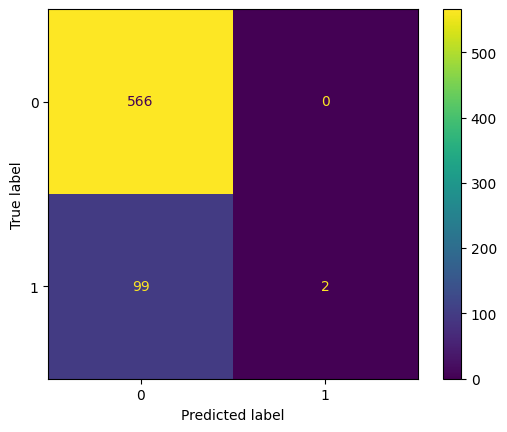

In [16]:
conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()

## 4 - Resampled Grid Search ##

### 4.1 - Resampling ###

In [17]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)
X_rs_train, X_rs_test, y_rs_train, y_rs_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)

### 4.2 - Grid setting ###

In [18]:
params_rf = {"max_depth": np.arange(2,12),
            "min_samples_leaf": [0.04, 0.06, 0.08, 0.1],
            "max_features" : ['log2', 'sqrt'],
            "n_estimators": [300, 400, 500]}

rf = RandomForestClassifier(random_state = 42)
grid_rf_rs = GridSearchCV(estimator = rf, param_grid = params_rf, scoring = 'recall', cv = 10, verbose = 1, n_jobs = -1)

### 4.3 - Fitting and finding the best model ###

In [19]:
grid_rf_rs.fit(X_rs_train, y_rs_train)
print(grid_rf_rs.best_params_, grid_rf_rs.best_score_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
{'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 0.04, 'n_estimators': 400} 0.816429587482219


### 4.4 - Evaluating the best model ###

In [20]:
best_model = grid_rf_rs.best_estimator_
y_rs_pred = best_model.predict(X_rs_test)
print(classification_report(y_rs_test, y_rs_pred, digits = 3))

              precision    recall  f1-score   support

           0      0.753     0.839     0.793        87
           1      0.856     0.776     0.814       107

    accuracy                          0.804       194
   macro avg      0.804     0.807     0.804       194
weighted avg      0.809     0.804     0.805       194



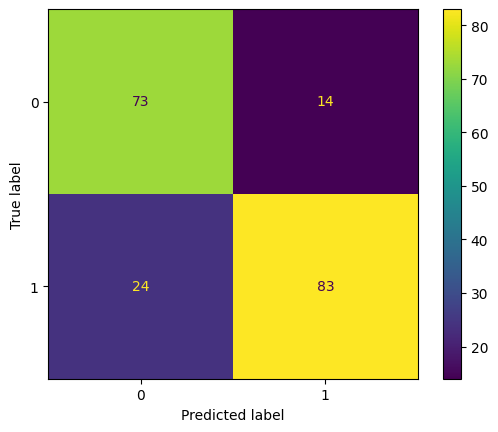

In [21]:
conf_mat2 = confusion_matrix(y_rs_test, y_rs_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat2)
disp.plot()